In [14]:
import argparse
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
import itertools
import os
import importlib
from IPython.display import Image, display, HTML
import glob
import importlib
import sys
from itertools import cycle
print(sys.version)

sys.path.insert(0, '/home/biddisco/src/maestro/pegasus-workflow-development-environment/shared-data/maestro-test/results')
# my modules in $HOME/src/python
import maestro_plotutils as pu

3.9.5 (default, May 11 2021, 08:20:37) 
[GCC 10.3.0]


In [15]:
if pu.is_notebook():
    # this makes the notebook wider on a larger screen using %x of the display
    display(HTML("<style>.container { width:100% !important; }</style>"))
    # save this notebook as a raw python file as well please
    get_ipython().system('jupyter nbconvert --to script maestro-plot.ipynb')

# Tell pandas to display more columns without wrapping in dataframe output
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

[NbConvertApp] Converting notebook maestro-plot.ipynb to script
[NbConvertApp] Writing 6308 bytes to maestro-plot.py


In [16]:
csv_columns = ['Args_size', 'iterations', 'forks', 'beegfs', 'Elapsed'],

# -------------------------------------------------
# This will read the output of future_overhead --csv
# -------------------------------------------------
def read_maestro_benchmark_csv(name):
    print('Reading',name)
    data = pd.read_csv(
        name,
        header=None,
        comment='#',
        sep='\s*,\s*', # regex to skip whitespace and use comma separator
        engine='python',
        skipinitialspace=True)

    # Data layout is 
    # CSVData, Args_size, 1073741824, iterations, 5, forks, 2, IO, lustre, Elapsed, 38.386520862579346
    
    # list slicing syntax is data[start:stop:step]
    # for rows, cols, we use data.iloc[(row)start:stop:step , (col)start:stop:step]
    #
    # columns names are in columns 0,2,4,6
    # column data   are in columns 1,3,5,7
    cleaned = data.iloc[::,2::2] # all rows, cols 2,4,6,8, ....
    cleaned.columns = list(data.iloc[0,1::2]) # col names are row 0, col 1,3,5,7 ...
    print('Column names:', cleaned.columns)
    #pu.title_print('File ' + name, cleaned)
    return cleaned

In [23]:
def load_maestro_benchmark_files(filenames, hostname, info):
    alldata = pd.DataFrame()
    for filename in filenames:
        data = read_maestro_benchmark_csv(filename)
        # fill empty info NaN info columns with ""
        data.fillna('', inplace=True)
        if ('info' not in data) or (info!=''):
            print('Setting info to', info)
            data['info'] = info
        data['date']     = date_str
        data['hostname'] = hostname
        alldata = pd.concat([alldata, data], sort=False)
    return alldata

def load_maestro_benchmark_files_in_dir(data_root, date_str, prefix='', ext='*.txt', hostname='none', info=''):
    alldata = pd.DataFrame()
    dirname = os.path.join(data_root, date_str)
    if prefix != '':
        filenames = glob.glob(os.path.join(dirname, prefix + ext))
        print('glob', os.path.join(dirname, prefix + ext))
        data = load_maestro_benchmark_files(filenames, hostname, info)
        alldata = pd.concat([alldata, data], sort=False)
    else:
        for m in ['ault', 'daint', 'tave', 'jb-s76', 'pop-os']:
            filenames = glob.glob(os.path.join(dirname, m + ext))
            print('glob', os.path.join(dirname, prefix + ext))
            print('Calling load with hostname', m)
            data = load_maestro_benchmark_files(filenames, m, info)
            alldata = pd.concat([alldata, data], sort=False)
    #pu.title_print('Data from ' + dirname, alldata)
    pu.add_to_global_data(alldata, os.path.join(dirname, prefix))
    return alldata

In [24]:
importlib.reload(pu);

In [25]:
def reset_data():
    pu.global_dataframe = pd.DataFrame(columns=csv_columns)
    pu.global_dataframe.index.name = 'index'
    pu.global_datadict = {}

reset_data()

In [26]:
machine_desc = {'ault'  :'Ault \n (AMD EPYC 7501@2GHz) \n 32x2-Cores (128 pu) \n 8 numa',
                'daint' :'Daint \n (Xeon E5-2695v4@2.10GHz) \n 18*2 Cores (72 pu) \n 2 numa',
                'tave'  :'Tave \n KNL-Xeon-Phi 7230@1.30GHz \n 64 Cores (256 pu) \n 1 numa',
                'jb-s76':'Laptop \n 4 Cores (8 pu) \n 1 numa',
                'pop-os':'Laptop \n i7-6700HQ@2.60GHz \n 4 Cores (8 pu) \n 1 numa'
                }

In [27]:
importlib.reload(pu);
date_str  = '2021-11-17'
data_root = '/home/biddisco/benchmarking-results/maestro/'
data      = load_maestro_benchmark_files_in_dir(data_root, '', prefix='daint-', ext="*.txt", hostname='daint', info='#1')

# generate total memory column, for our simple graph
# 1*forks*size + 2*forks*iterations*size + 1*forks*size 
data['total_memory'] = (data['Args_size']*(2*data['forks']*data['iterations'] + 2*data['forks'])) / (1024 *1024 * 1024)
data['BW'] = data['total_memory']/data['Elapsed']
data['Size (GB)'] = round(data['Args_size']/(1024*1024*1024))
data = data.replace('cdo','CDO', regex=False)
#data.reset_index(inplace=True)
data.index.rename('index',inplace=True)
data = data[['iterations','forks','IO','BW','Size (GB)']]
#data.sort_values('IO', axis=1, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)
pu.title_print('Data', data)

glob /home/biddisco/benchmarking-results/maestro/daint-*.txt
Reading /home/biddisco/benchmarking-results/maestro/daint-cdo-1.txt
Column names: Index(['Args_size', 'iterations', 'forks', 'IO', 'Elapsed'], dtype='object')
Setting info to #1
Reading /home/biddisco/benchmarking-results/maestro/daint-beegfs-1.txt
Column names: Index(['Args_size', 'iterations', 'forks', 'IO', 'Elapsed'], dtype='object')
Setting info to #1
Reading /home/biddisco/benchmarking-results/maestro/daint-lustre-1.txt
Column names: Index(['Args_size', 'iterations', 'forks', 'IO', 'Elapsed'], dtype='object')
Setting info to #1
Reading /home/biddisco/benchmarking-results/maestro/daint-lustre-2.txt
Column names: Index(['Args_size', 'iterations', 'forks', 'IO', 'Elapsed'], dtype='object')
Setting info to #1
Reading /home/biddisco/benchmarking-results/maestro/daint-beegfs-2.txt
Column names: Index(['Args_size', 'iterations', 'forks', 'IO', 'Elapsed'], dtype='object')
Setting info to #1
Reading /home/biddisco/benchmarking-r

Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW
Groups [] x iterations y BW


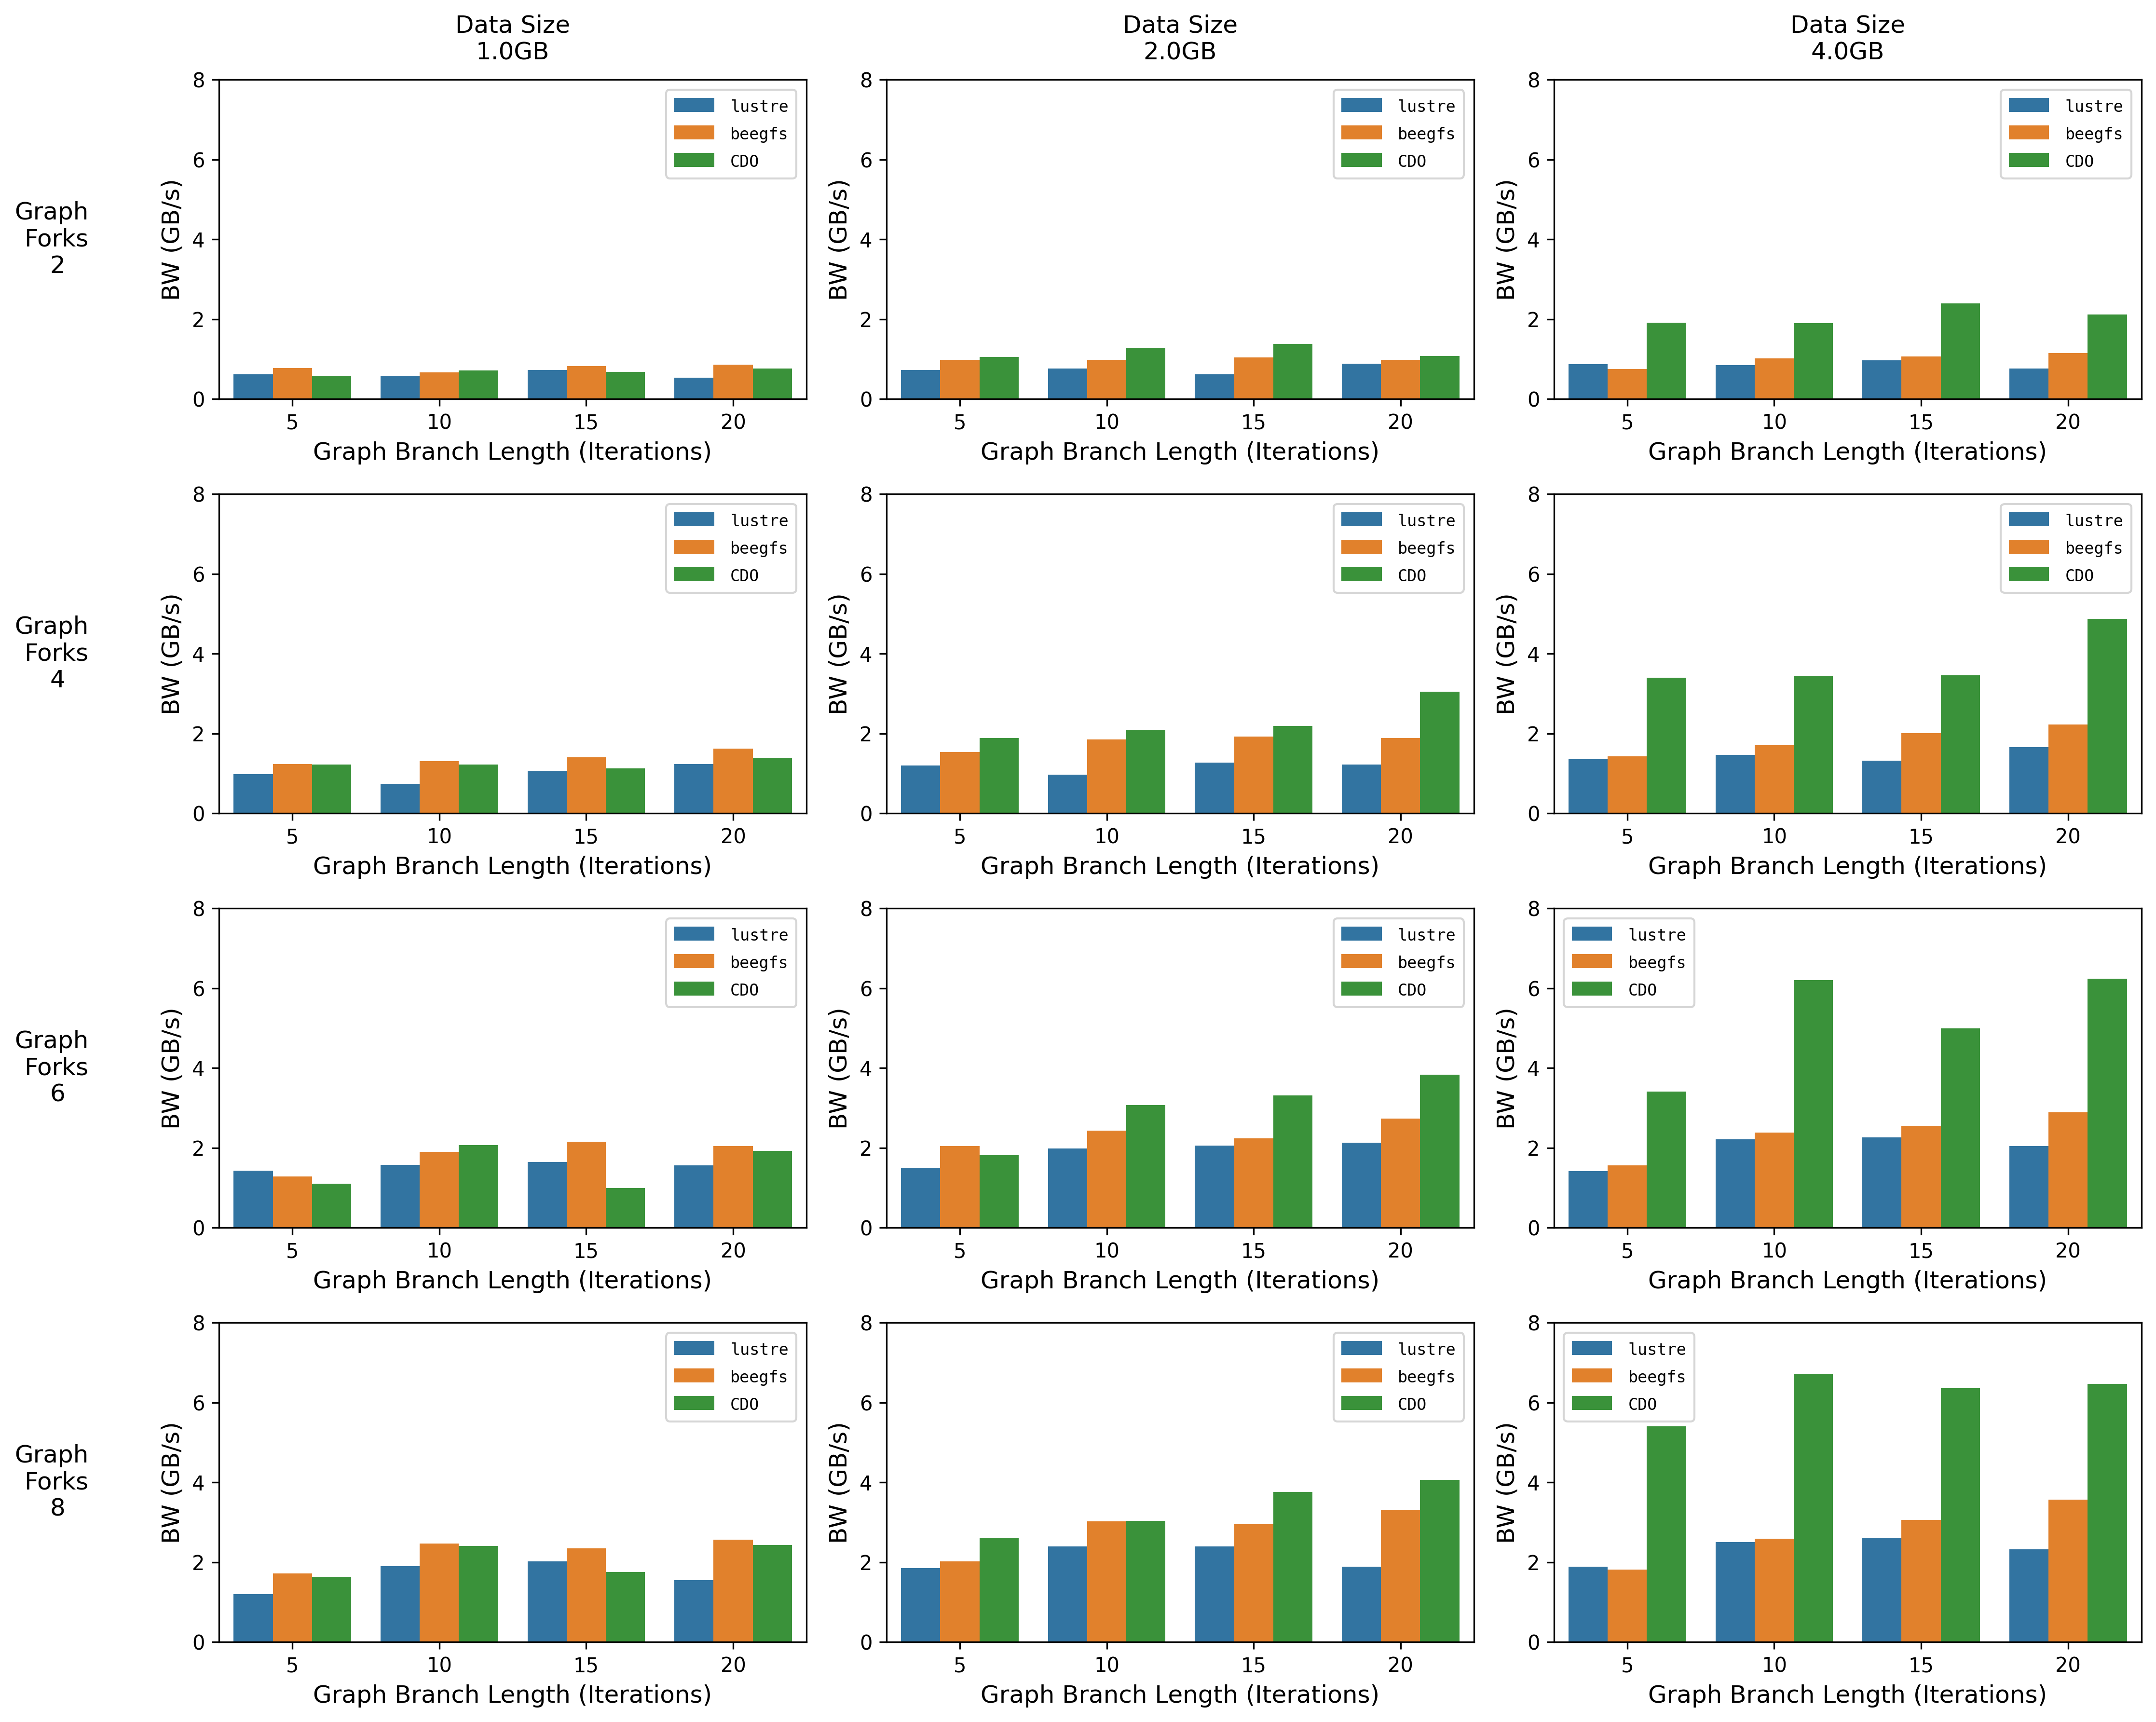

In [28]:
importlib.reload(pu);

lparams       = pu.legend(enabled=True,
                          fontname='DejaVu Sans Mono',
                          fontsize=8,
                          ncol=1,
                          format=lambda t,v:str(v))

cparams       = pu.rowcol(format=lambda t,v: 'Data Size' + '\n' + str(v) +'GB')
rparams       = pu.rowcol(format=lambda t,v: 'Graph\nForks\n' + str(v) + '   ') 
rows, columns = ['forks'],['Size (GB)']
select        = {}
plotvars      = {'x':'iterations', 'y':'BW'}
xparams       = pu.axis(label='Graph Branch Length (Iterations)', scale=None)
                        
yparams       = pu.axis(label='BW (GB/s)' , limits=(0,8), scale='linear', base=10, format=None)
fig = pu.plot_graph_series(data, rows, columns, select, plotvars, xparams, yparams, size=(5,3,300), rparams=rparams, cparams=cparams, lparams=lparams)
fig[0].savefig('maestro-benchmarks.pdf')

Groups [] x forks y BW
Groups [] x forks y BW
Groups [] x forks y BW


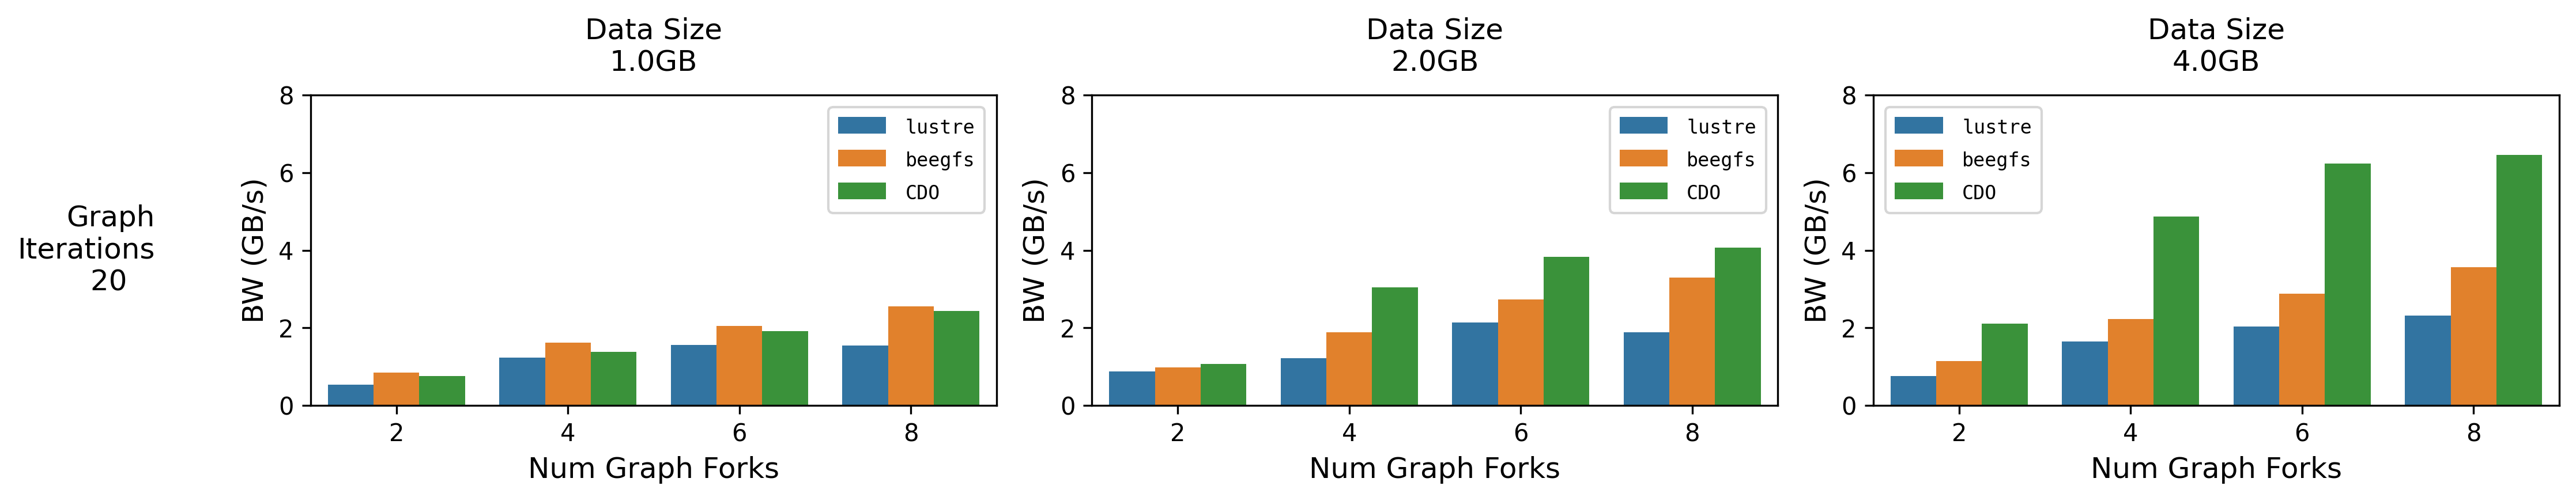

In [34]:
importlib.reload(pu);

lparams       = pu.legend(enabled=True,
                          fontname='DejaVu Sans Mono',
                          fontsize=8,
                          ncol=1,
                          format=lambda t,v:str(v))

cparams       = pu.rowcol(format=lambda t,v: 'Data Size' + '\n' + str(v) +'GB')
rparams       = pu.rowcol(format=lambda t,v: 'Graph\nIterations\n' + str(v) + '   ') 
rows, columns = ['iterations'],['Size (GB)']
select        = {'iterations':20}
plotvars      = {'x':'forks', 'y':'BW'}
xparams       = pu.axis(label='Num Graph Forks', scale=None)
                        
yparams       = pu.axis(label='BW (GB/s)' , limits=(0,8), scale='linear', base=10, format=None)
fig = pu.plot_graph_series(data, rows, columns, select, plotvars, xparams, yparams, size=(5,3,300), rparams=rparams, cparams=cparams, lparams=lparams)
fig[0].savefig('maestro-forks.pdf')